In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import joblib

In [2]:
import os
# Set working directory
os.chdir("D:/ACP")  # Windows path fix: use forward slash or raw string

print("Current Working Directory:", os.getcwd())

Current Working Directory: D:\ACP


In [3]:
# Step 1: Load the datasets (datasets were already splited and saved as csv files, 80,20 split)
train_data = pd.read_csv("acp_train_data.csv") #train data
test_data = pd.read_csv("acp_test_data.csv") #test data
# Step 2: Separate labels and features
y_train, X_train = train_data.iloc[:, 2], train_data.iloc[:, 3:] # third column: Label, # from fourth column onward: features
y_test, X_test = test_data.iloc[:, 2], test_data.iloc[:, 3:]

In [4]:
# Define GaussianNB model and parameter grid
gnb_model = GaussianNB() #it doesnnot need Random state for reproducibility
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5] #var_smoothing means the variance of the data. The smaller the value, the more the variance
}

# Apply GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=gnb_model,
    param_grid=param_grid,
    scoring='accuracy', # use accuracy as the scoring metric
    cv=5,
    n_jobs= 1, #use all available cores, -1 value means using all cores, 0 means using 1 core, 1 means using 2 cores and so on
    verbose=2 # print grid search results, verbose=0 means silent, 1 means print progress, 2 means print progress and results
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ................................var_smoothing=1e-09; total time=   0.2s
[CV] END ................................var_smoothing=1e-09; total time=   0.2s
[CV] END ................................var_smoothing=1e-09; total time=   0.2s
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.2s
[CV] END ................................var_smoothing=1e-08; total time=   0.2s
[CV] END ................................var_smoothing=1e-07; total time=   0.2s
[CV] END ................................var_smoo

GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=1,
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]},
             scoring='accuracy', verbose=2)

In [5]:
#Print best parameters
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best model from GridSearchCV
best_gnb_model = grid_search.best_estimator_

# Save best hyperparameters to a file
with open('best_model_info_gnb.txt', 'w') as f:
    f.write("Best Hyperparameters:\n")
    for param, value in grid_search.best_params_.items():
        f.write(f"{param}: {value}\n")

print("Best model information has been saved to 'best_model_info_gnb.txt'")

Best Hyperparameters: {'var_smoothing': 1e-09}
Best model information has been saved to 'best_model_info_gnb.txt'


In [6]:
#save best model to a file
joblib.dump(best_gnb_model, "best_gnb_model.pkl")

['best_gnb_model.pkl']

In [7]:
# Fit the model on the training data
best_gnb_model.fit(X_train, y_train)

# Evaluate on the test dataset
y_test_pred = best_gnb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Confusion Matrices
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (Test Data):\n", confusion_matrix_test)

# Sensitivity and Specificity calculation
def calculate_sensitivity_specificity(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

sensitivity_test, specificity_test = calculate_sensitivity_specificity(confusion_matrix_test)
print("Test Data - Sensitivity:", sensitivity_test, "Specificity:", specificity_test)

Test Accuracy: 0.6648648648648648
Confusion Matrix (Test Data):
 [[54 37]
 [25 69]]
Test Data - Sensitivity: 0.7340425531914894 Specificity: 0.5934065934065934


In [8]:
from sklearn.metrics import f1_score
# calculation of F1 score
f1_test = f1_score(y_test, y_test_pred)
print("F1 Score (Test Data):", f1_test)

F1 Score (Test Data): 0.69


In [9]:
#calculation of classification report for test and evaluation data
print("Classification Report (Test Data):\n", classification_report(y_test, y_test_pred))

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.68      0.59      0.64        91
           1       0.65      0.73      0.69        94

    accuracy                           0.66       185
   macro avg       0.67      0.66      0.66       185
weighted avg       0.67      0.66      0.66       185



In [10]:
# Evaluate on the test dataset
y_test_pred = best_gnb_model.predict(X_test)
y_test_prob = best_gnb_model.predict_proba(X_test)[:, 1]

Test Data ROC AUC: 0.6637245732990413
Test Data FPR: [0.         0.40659341 1.        ]
Test Data TPR: [0.         0.73404255 1.        ]
Test Data Thresholds: [inf  1.  0.]
ROC curve saved as 'gnb_roc_auc_curve.png'.


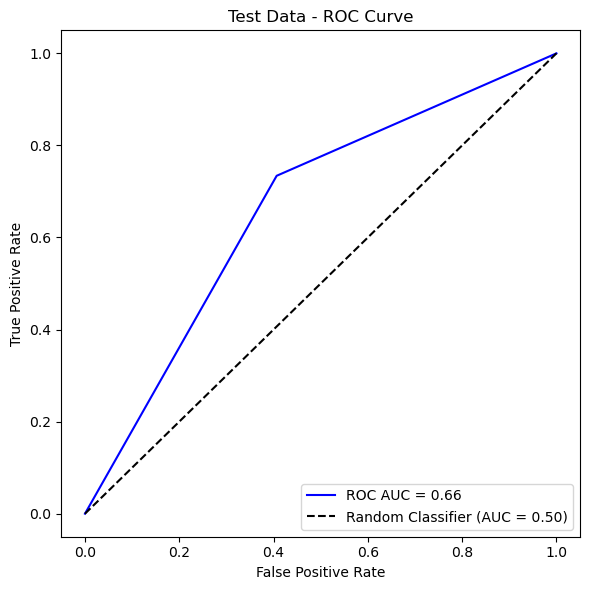

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate ROC for test dataset
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Print the values
print("Test Data ROC AUC:", roc_auc_test)
print("Test Data FPR:", fpr_test)
print("Test Data TPR:", tpr_test)
print("Test Data Thresholds:", thresholds_test)

# Create a plot
fig, ax = plt.subplots(figsize=(6, 6))  # This defines 'ax' properly

# Plot ROC curve
ax.plot(fpr_test, tpr_test, label=f"ROC AUC = {roc_auc_test:.2f}", color="blue")
ax.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.50)")
ax.set_title("Test Data - ROC Curve")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("gnb_roc_auc_curve.png", dpi=500)
print("ROC curve saved as 'gnb_roc_auc_curve.png'.")

# Show the plot
plt.show()


In [12]:
# Perform 10-fold cross-validation on the best model
cross_val_scores = cross_val_score(best_gnb_model, X_train, y_train, cv=10, scoring='accuracy')
print("10-Fold Cross-Validation Accuracy Scores:", cross_val_scores)
print("Mean 10-Fold CV Accuracy:", cross_val_scores.mean())

# save accuracy of each fold to a text file
with open('cv_accuracies_gnb.txt', 'w') as f:
    f.write("Cross-Validation Accuracies for each fold:\n")
    for i, score in enumerate(cross_val_scores):
        f.write(f"Fold {i+1} Accuracy: {score:.4f}\n")

print("Accuracy of each fold has been saved to 'cv_accuracies_gnb.txt'")

10-Fold Cross-Validation Accuracy Scores: [0.75675676 0.7972973  0.74324324 0.66216216 0.74324324 0.74324324
 0.75675676 0.66216216 0.68493151 0.75342466]
Mean 10-Fold CV Accuracy: 0.7303221029248427
Accuracy of each fold has been saved to 'cv_accuracies_gnb.txt'


Mean Accuracy: 73.03
Mean AUC: 0.9533


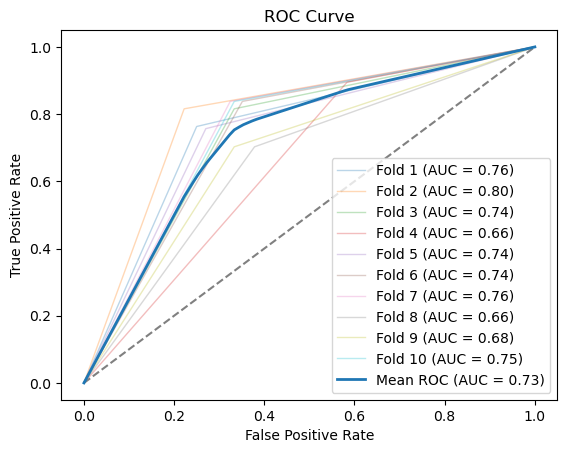

In [14]:
# make roc curve of all folds with mean auc and mean accuracy printed on the plot
mean_accuracy = cross_val_scores.mean() * 100
print(f"Mean Accuracy: {mean_accuracy:.2f}")
# Step 6: Generate ROC Curve
mean_auc = roc_auc_score(y_train, best_gnb_model.predict_proba(X_train)[:, 1])
print(f"Mean AUC: {mean_auc:.4f}")

cv = StratifiedKFold(n_splits=10)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for i, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    best_gnb_model.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
    y_prob = best_gnb_model.predict_proba(X_train.iloc[test_idx])[:, 1]
    fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], y_prob)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig("cv_roc_curve_gnb.png", dpi=500)
plt.show()

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef
# Compute metrics
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
mcc = matthews_corrcoef(y_test, y_test_pred)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Matthews Correlation Coefficient (MCC):", mcc)

Precision: 0.6509433962264151
Recall: 0.7340425531914894
F1 Score: 0.69
Matthews Correlation Coefficient (MCC): 0.3309497120717529
